In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

%matplotlib inline 
# Add this line BEFORE plotting (fixes 90% of freezes)

In [3]:
sns.set(style='whitegrid')


df = pd.read_csv("GBD_SDI_1950_2021.csv")
df.head(3)




,covariate_name_short,location_id,location_name,year_id,age_group_id,age_group_name,sex_id,sex,mean_value,lower_value,upper_value
0,sdi,1,Global,1950,22,All Ages,3,Both,0.369235,0.369235,0.369235
1,sdi,4,"Southeast Asia, East Asia, and Oceania",1950,22,All Ages,3,Both,0.205729,0.205729,0.205729
2,sdi,5,East Asia,1950,22,All Ages,3,Both,0.193972,0.193972,0.193972


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52992 entries, 0 to 52991
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   covariate_name_short  52992 non-null  object 
 1   location_id           52992 non-null  int64  
 2   location_name         52992 non-null  object 
 3   year_id               52992 non-null  int64  
 4   age_group_id          52992 non-null  int64  
 5   age_group_name        52992 non-null  object 
 6   sex_id                52992 non-null  int64  
 7   sex                   52992 non-null  object 
 8   mean_value            52992 non-null  float64
 9   lower_value           52992 non-null  float64
 10  upper_value           52992 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 4.4+ MB


In [5]:
# pick
year_col = "year_id"
loc_col = "location_name"
sdi_col = "mean_value"
print('Using columns -> year:', year_col, 'location:', loc_col, 'sdi:', sdi_col)


# Convert year

Using columns -> year: year_id location: location_name sdi: mean_value


In [6]:
# Convert year
df[year_col] = df[year_col].astype(int)


# Create minimal DF
if sdi_col is None:
    raise ValueError('Cannot find an SDI column automatically. Please inspect df.columns and adjust sdi_col in the notebook.')


mini = df[[loc_col, year_col, sdi_col]].copy()
mini = mini.rename(columns={loc_col: 'location', year_col: 'year', sdi_col: 'sdi'})
mini['sdi'] = pd.to_numeric(mini['sdi'], errors='coerce')


print('\nMinimal DF sample:')
print(mini.head())


Minimal DF sample:
                                 location  year       sdi
0                                  Global  1950  0.369235
1  Southeast Asia, East Asia, and Oceania  1950  0.205729
2                               East Asia  1950  0.193972
3                                   China  1950  0.184144
4   Democratic People's Republic of Korea  1950  0.323069


In [7]:
# Additional columns: extract country
# If dataset contains 'location_type' or 'region'

# Quick stats
print('\nSDI overall summary:')
print(mini['sdi'].describe())


# number of unique locations
print('Unique locations:', mini['location'].nunique())


SDI overall summary:
count    52992.000000
mean         0.531716
std          0.221904
min          0.027020
25%          0.342165
50%          0.569437
75%          0.719158
max          0.946477
Name: sdi, dtype: float64
Unique locations: 732


In [8]:
# 1 Global average SDI over time
# 2 SDI World Map (2021)
# 3 Distribution of SDI (2021)
# 4.1 Top 10 SDI in 2021
# 4.2 Bottom 10 SDI in 2021
# 5 Heatmap for selected countries
# 6 Top 10 Countries by Total SDI Change (1950–2021)


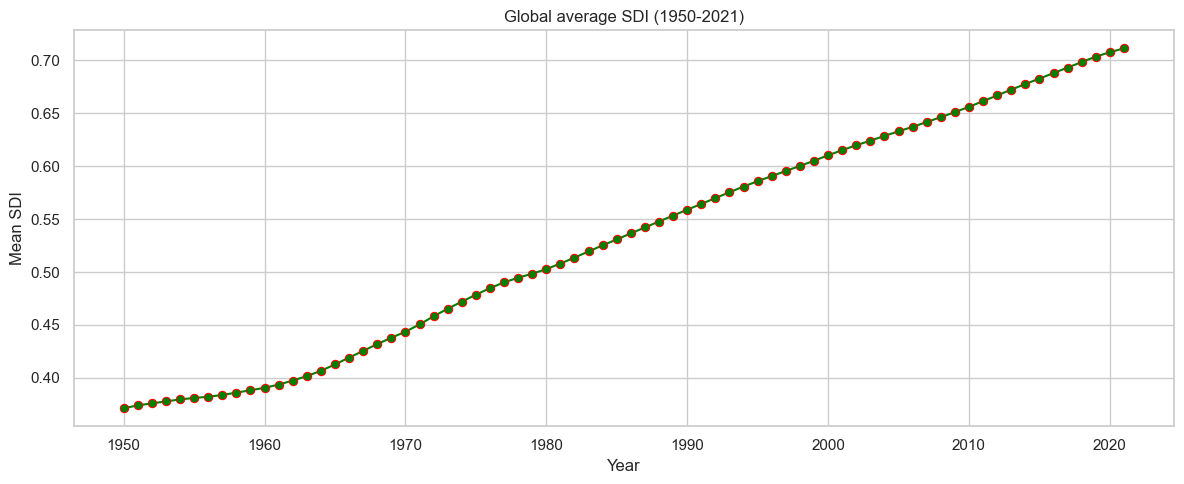

In [9]:

# 1) Global average SDI over time
global_trend = mini.groupby('year')['sdi'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=global_trend, x='year', y='sdi',color ="green",marker ="o",markeredgecolor='red')
plt.title('Global average SDI (1950-2021)')
plt.ylabel('Mean SDI')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

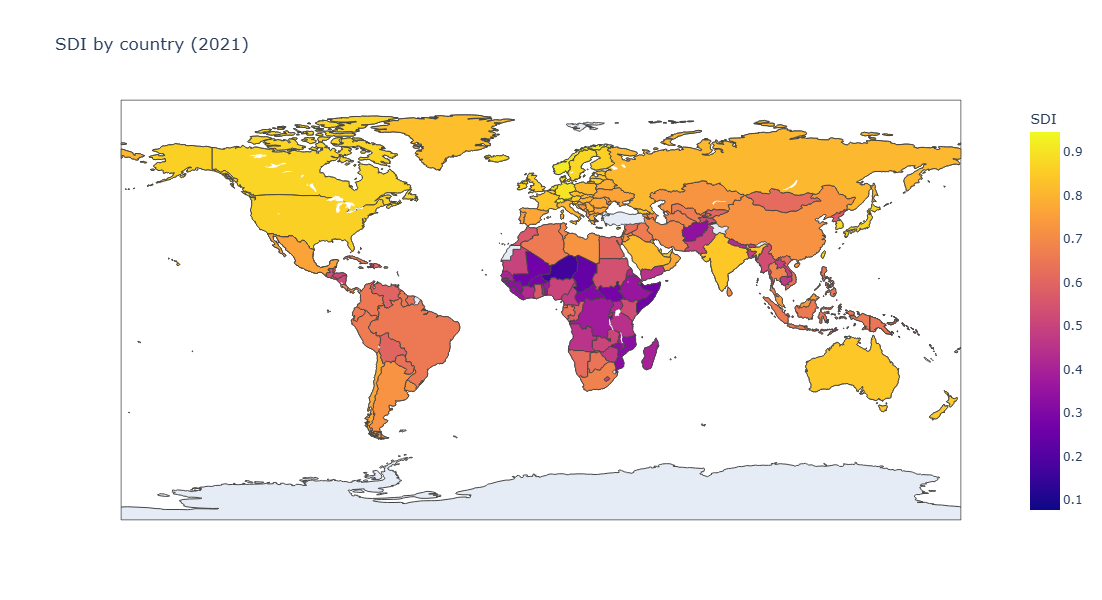

In [23]:
# 2 SDI World Map (2021)
snapshot_2021 = mini[mini['year']==2021].copy()
# plotly expects ISO codes for best results; try to use 'location' as names
fig = px.choropleth(snapshot_2021,locations='location',locationmode='country names',color='sdi',title='SDI by country (2021)',labels={'sdi': 'SDI'})
fig.update_layout(width=1000, height=600)
fig.show()


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


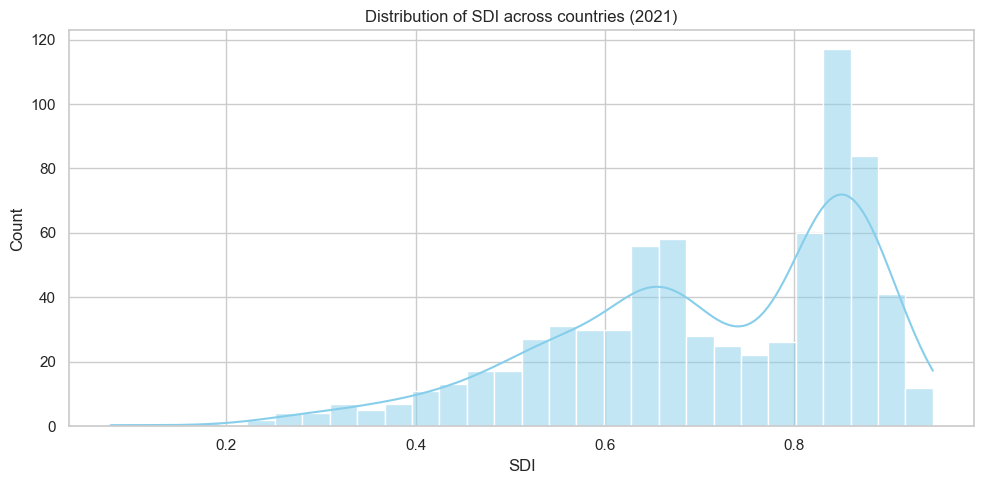

In [14]:
# 3 Distribution of SDI (2021)

plt.close('all')  # prevents Jupyter from freezing
plt.figure(figsize=(10,5))
sns.histplot(snapshot_2021['sdi'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of SDI across countries (2021)')
plt.xlabel('SDI')
plt.tight_layout()

plt.show()


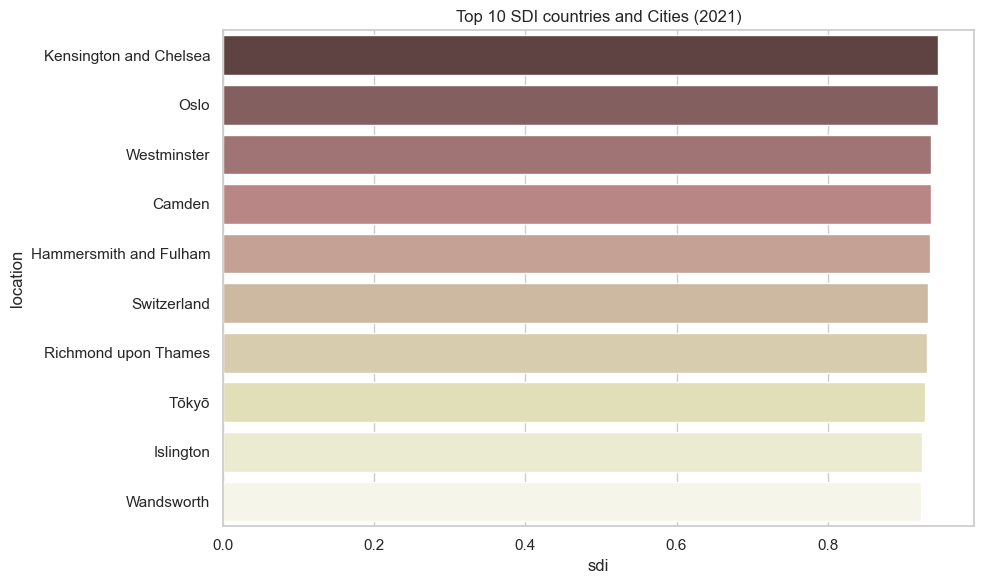

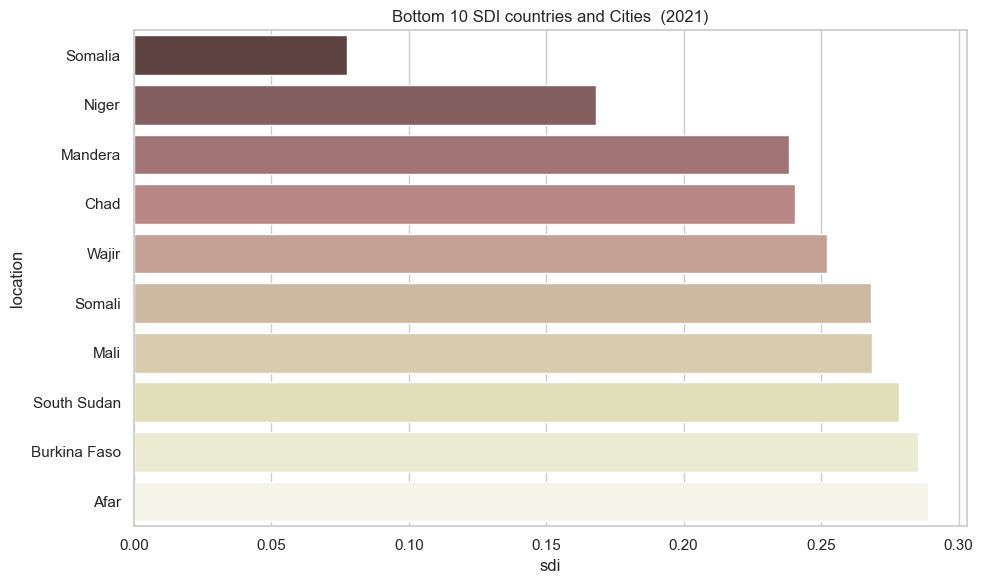

In [25]:
# 4.1 Top 10 SDI in 2021
plt.figure(figsize=(10,6))

top10 = snapshot_2021.sort_values('sdi', ascending=False).head(10)
bot10 = snapshot_2021.sort_values('sdi', ascending=True).head(10)

sns.barplot(y='location',x='sdi',data=top10,hue = "location",palette='pink')
# here "palette" give different colors automatically
plt.title('Top 10 SDI countries and Cities (2021)')
plt.tight_layout()
plt.show()

# 4.2 Bottom 10 SDI in 2021
plt.figure(figsize=(10,6))
sns.barplot(y='location', x='sdi', data=bot10,hue = "location",palette='pink')
# here "palette" give different colors automatically
plt.title('Bottom 10 SDI countries and Cities  (2021)')
plt.tight_layout()
plt.show()


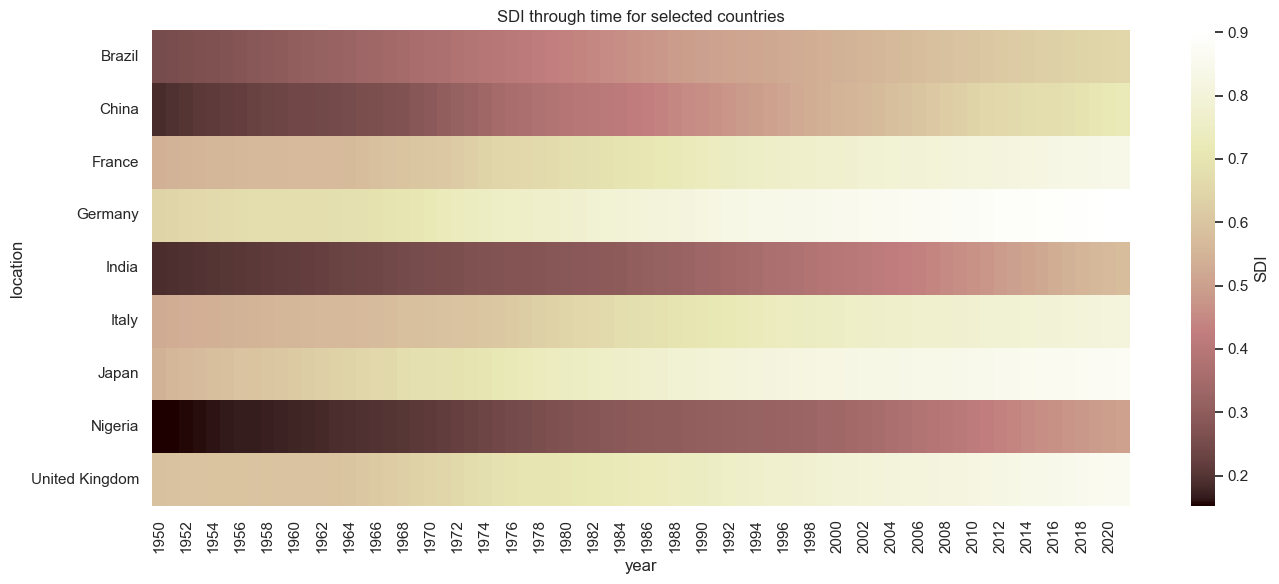

In [16]:

# 5) Heatmap for selected countries
selected_countries = ['Italy','United States','China','India','Brazil','Nigeria','Germany','France','United Kingdom','Japan']
heat_df = mini[mini['location'].isin(selected_countries)].pivot(index='location', columns='year', values='sdi')
plt.figure(figsize=(14,6))
sns.heatmap(heat_df, cmap='pink', cbar_kws={'label':'SDI'})
plt.title('SDI through time for selected countries')
plt.tight_layout()
plt.show()

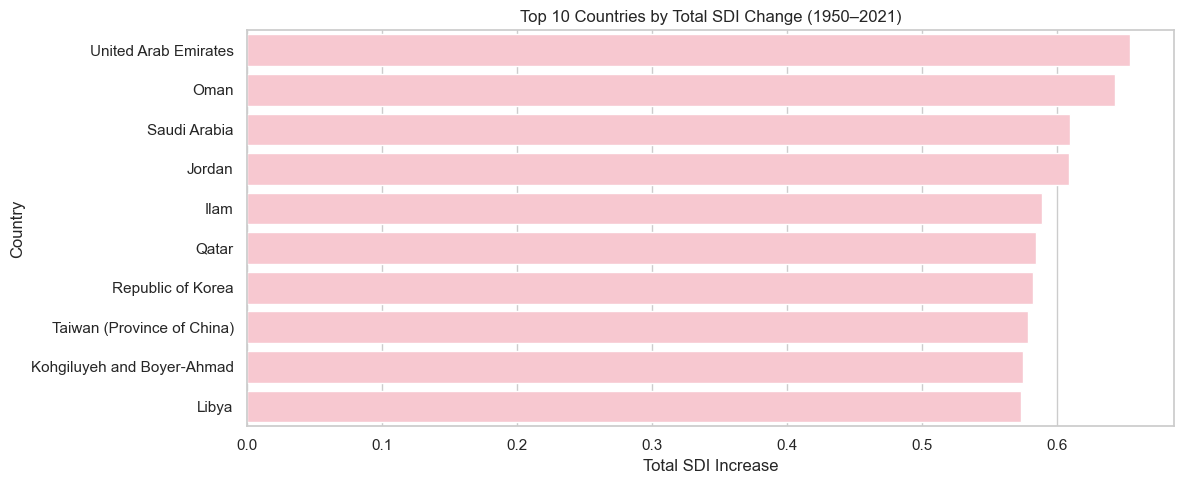

In [20]:
# 6 Top 10 Countries by Total SDI Change (1950–2021)
mini['sdi_diff'] = mini.groupby('location')['sdi'].diff()  # year-to-year difference
total_change = mini.groupby('location')['sdi_diff'].sum().sort_values(ascending=False)
top10 = total_change.head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=top10.values, y=top10.index, color='pink')  # All bars pink
plt.title("Top 10 Countries by Total SDI Change (1950–2021)")
plt.xlabel("Total SDI Increase")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [57]:
# Italy-focused analysis
# 1 Italy SDI time series (1950-2021)
# 2 Italy vs Europe: compute Europe mean
# 3 Italy rolling average
# 4 Italy rank over time
# 5 Forecast Italy SDI to 2035 using ARIMA (simple, univariate)
# 6 Italy SDI Rolling Averages 5,10,20 YEARS
# 7 Italy vs Asian countries
# 8 Italy vs Asian Peer Group Average


In [58]:
country = 'Italy'
italy = mini[mini['location']==country].sort_values('year')

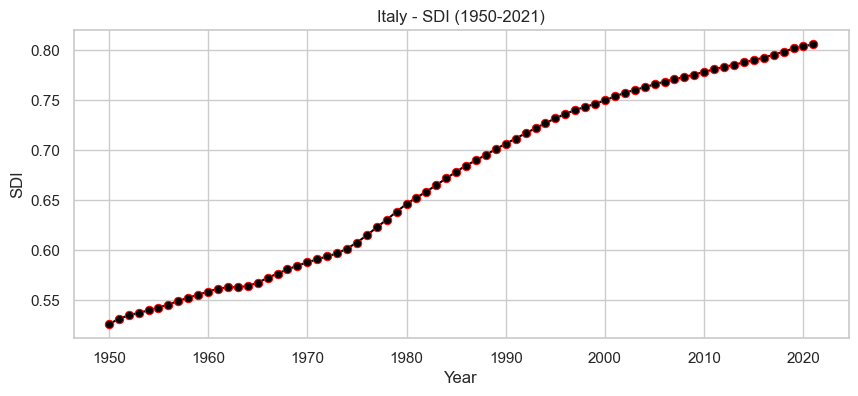

In [59]:
# 1 Italy SDI time series (1950-2021)
plt.figure(figsize=(10,4))
sns.lineplot(data=italy, x='year', y='sdi',color = "Black", marker='o',markeredgecolor ="red")
plt.title('Italy - SDI (1950-2021)')
plt.ylabel('SDI')
plt.xlabel('Year')
plt.show()

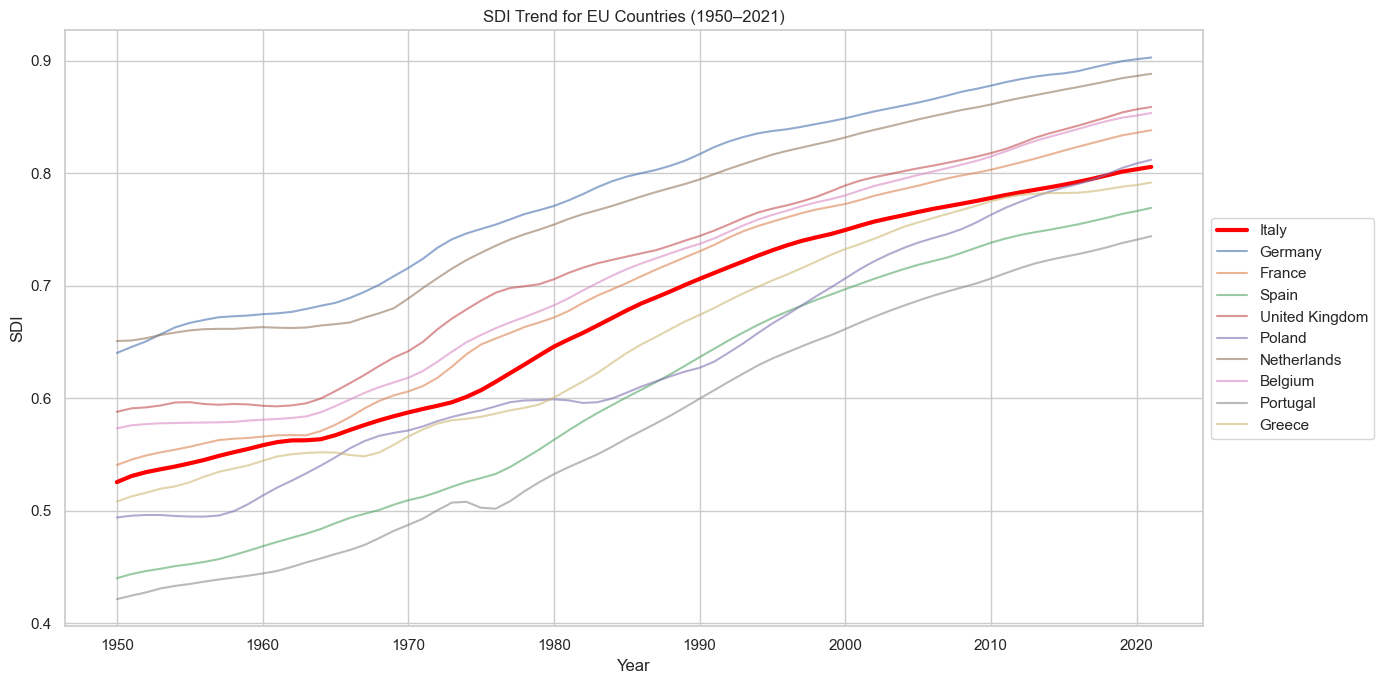

In [98]:
# 2 Italy vs Europe: compute Europe mean
# List of EU countries to plot
eu_countries = ['Italy','Germany','France','Spain','United Kingdom','Poland','Netherlands','Belgium','Portugal','Greece']

plt.figure(figsize=(14,7))

# Highlight Italy
sns.lineplot(data=df[df['location_name']=='Italy'],x='year_id',y='mean_value',linewidth=3,
    label='Italy',color='red')

# Plot other EU countries
for loc in eu_countries:
    if loc == 'Italy':
        continue
    sub = df[df['location_name'] == loc]
    sns.lineplot(data=sub,x='year_id',y='mean_value',alpha=0.6,label=loc)

plt.title("SDI Trend for EU Countries (1950–2021)")
plt.ylabel("SDI")
plt.xlabel("Year")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


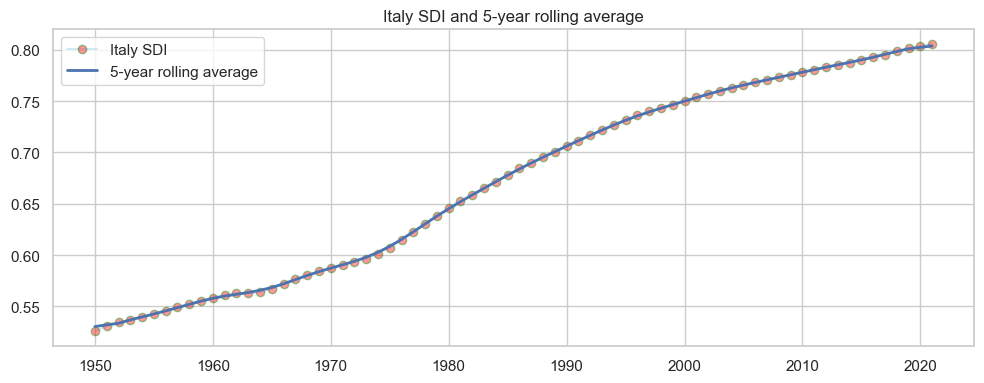

In [61]:
# 3 Italy rolling average
italy['sdi_5yr'] = italy['sdi'].rolling(window=5, center=True, min_periods=1).mean()
plt.figure(figsize=(10,4))
plt.plot(italy['year'], italy['sdi'], alpha=0.4, label='Italy SDI',color='skyblue',          # line color
    marker='o',markerfacecolor='red',markeredgecolor='green') 
plt.plot(italy['year'], italy['sdi_5yr'], label='5-year rolling average', linewidth=2)
plt.title('Italy SDI and 5-year rolling average')
plt.legend()
plt.tight_layout()
plt.show()

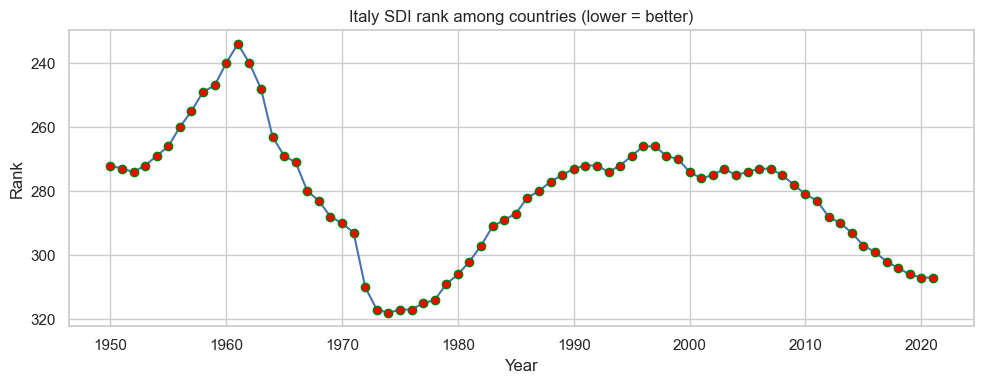

In [62]:
# 4 Italy rank over time
rank_df = mini[mini['year'].between(1950,2021)].copy()
rank_df['rank'] = rank_df.groupby('year')['sdi'].rank(ascending=False, method='min')
italy_rank = rank_df[rank_df['location']==country][['year','rank']]
plt.figure(figsize=(10,4))
plt.plot(italy_rank['year'], italy_rank['rank'],marker='o',markerfacecolor='red',markeredgecolor='green')
plt.gca().invert_yaxis()
plt.title('Italy SDI rank among countries (lower = better)')
plt.ylabel('Rank')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

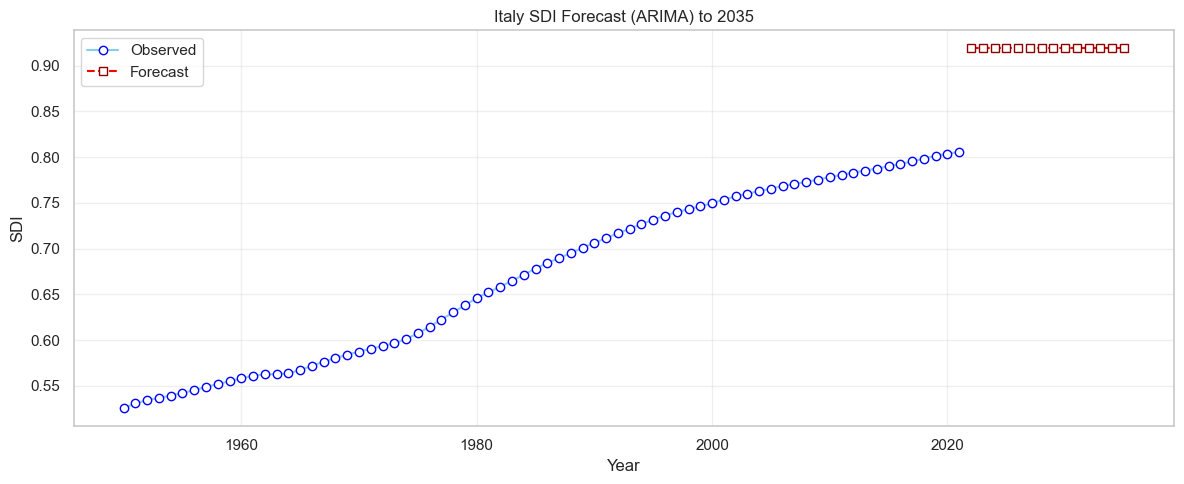

In [63]:
# 5 Forecast Italy SDI to 2035 using ARIMA (simple, univariate)
plt.close('all')
# Fit ARIMA(p,d,q) with simple parameters; in production we would grid-search
train = italy.set_index('year')['sdi'].dropna()
if len(train) >= 10:
    model = ARIMA(train, order=(1,1,1)).fit()
    preds = model.predict(start=train.index.max()+1, end=2035, typ='levels')
    
    plt.figure(figsize=(12,5))
    
    # Observed
    plt.plot(train.index, train.values, 'o-', color='skyblue',
             markerfacecolor='white', markeredgecolor='blue', label='Observed')
    
    # Forecast
    plt.plot(preds.index, preds.values, 's--', color='red',
             markerfacecolor='white', markeredgecolor='darkred', label='Forecast')
    
    plt.title('Italy SDI Forecast (ARIMA) to 2035')
    plt.xlabel('Year')
    plt.ylabel('SDI')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Not enough data for ARIMA forecast.')


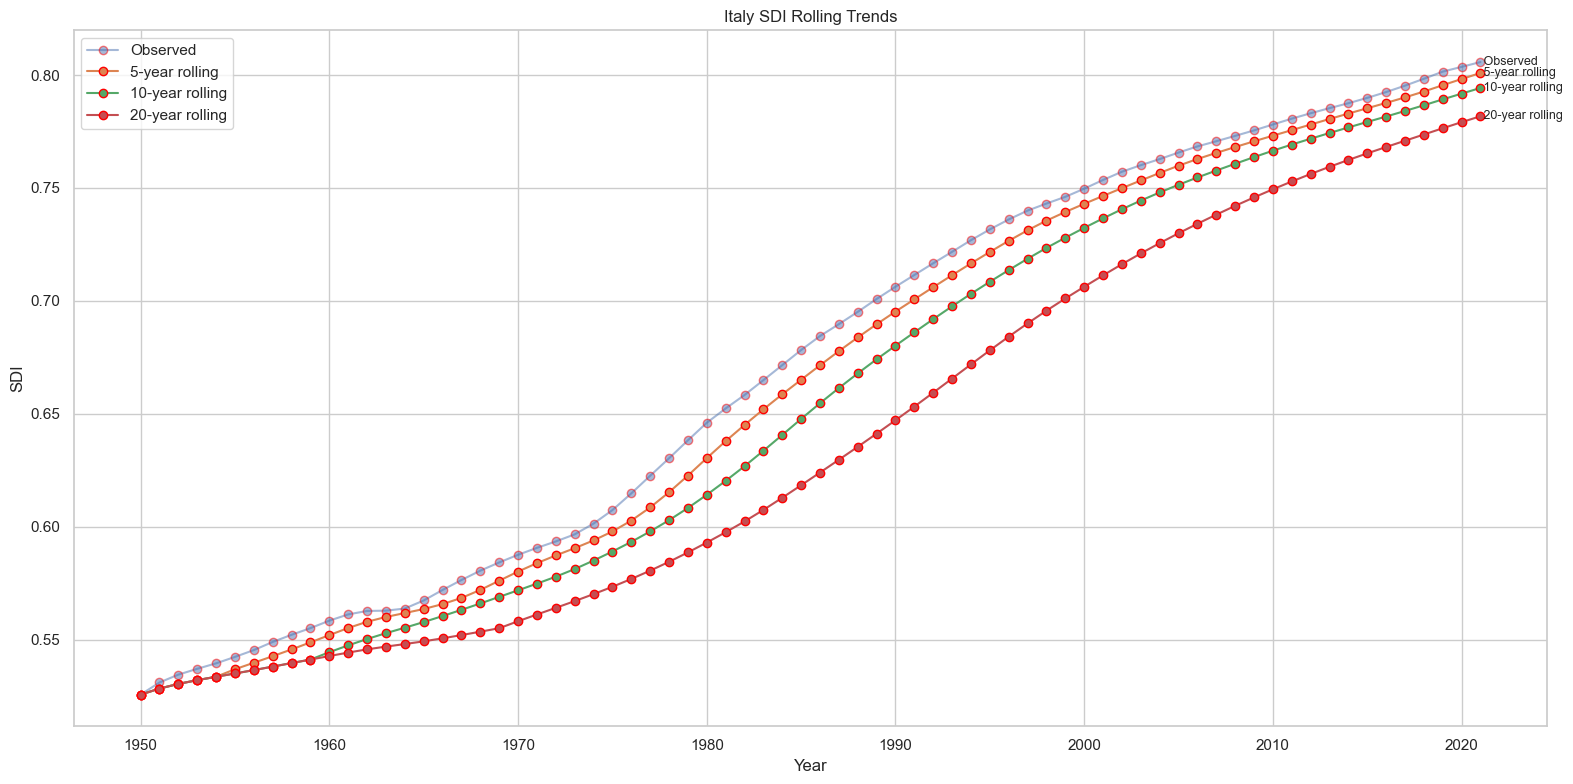

In [99]:
# 6 Italy SDI Rolling Averages 5,10,20 YEARS
italy = mini[mini['location'] == 'Italy'].sort_values('year').dropna(subset=['sdi'])

if italy.empty:
    print("Italy data not found.")
else:
    # 1) Rolling averages (very simple)
    italy['roll_5'] = italy['sdi'].rolling(5, min_periods=1).mean()
    italy['roll_10'] = italy['sdi'].rolling(10, min_periods=1).mean()
    italy['roll_20'] = italy['sdi'].rolling(20, min_periods=1).mean()

    plt.figure(figsize=(16,8))
    plt.plot(italy['year'], italy['sdi'], label='Observed', alpha=0.5,marker='o',markeredgecolor ="red")
    plt.plot(italy['year'], italy['roll_5'], label='5-year rolling',marker='o',markeredgecolor ="red")
    plt.plot(italy['year'], italy['roll_10'], label='10-year rolling',marker='o',markeredgecolor ="red")
    plt.plot(italy['year'], italy['roll_20'], label='20-year rolling',marker='o',markeredgecolor ="red")
    
    #Line labels
    plt.text(italy['year'].iloc[-1],italy['sdi'].iloc[-1],' Observed',fontsize=9,va='center')
    plt.text(italy['year'].iloc[-1],italy['roll_5'].iloc[-1],' 5-year rolling',fontsize=9,va='center')
    plt.text(italy['year'].iloc[-1],italy['roll_10'].iloc[-1],' 10-year rolling',fontsize=9,va='center')
    plt.text(italy['year'].iloc[-1],italy['roll_20'].iloc[-1],' 20-year rolling',fontsize=9,va='center')


    
    plt.title('Italy SDI Rolling Trends')
    plt.xlabel('Year'); plt.ylabel('SDI')
    plt.legend()
    plt.tight_layout()
    plt.show()





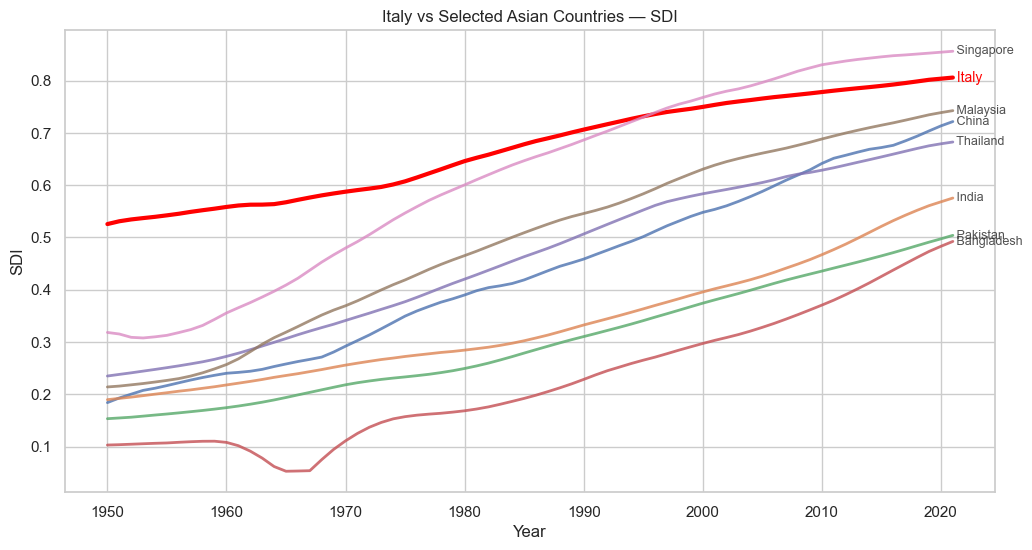

In [79]:
plt.figure(figsize=(12,6))

# Italy
italy_temp = subset[subset['location'] == 'Italy']
if not italy_temp.empty:
    plt.plot(italy_temp['year'], italy_temp['sdi'], linewidth=3, color='red')
    plt.text(italy_temp['year'].iloc[-1],italy_temp['sdi'].iloc[-1],' Italy',color='red',fontsize=10,va='center')

# Asian peers
for country in peers:
    temp = subset[subset['location'] == country]
    if temp.empty:
        continue
    plt.plot(temp['year'], temp['sdi'], linewidth=2, alpha=0.8)
    plt.text(temp['year'].iloc[-1],temp['sdi'].iloc[-1],f' {country}',fontsize=9,alpha=0.8,va='center')

plt.title('Italy vs Selected Asian Countries — SDI')
plt.xlabel('Year')
plt.ylabel('SDI')
plt.show()


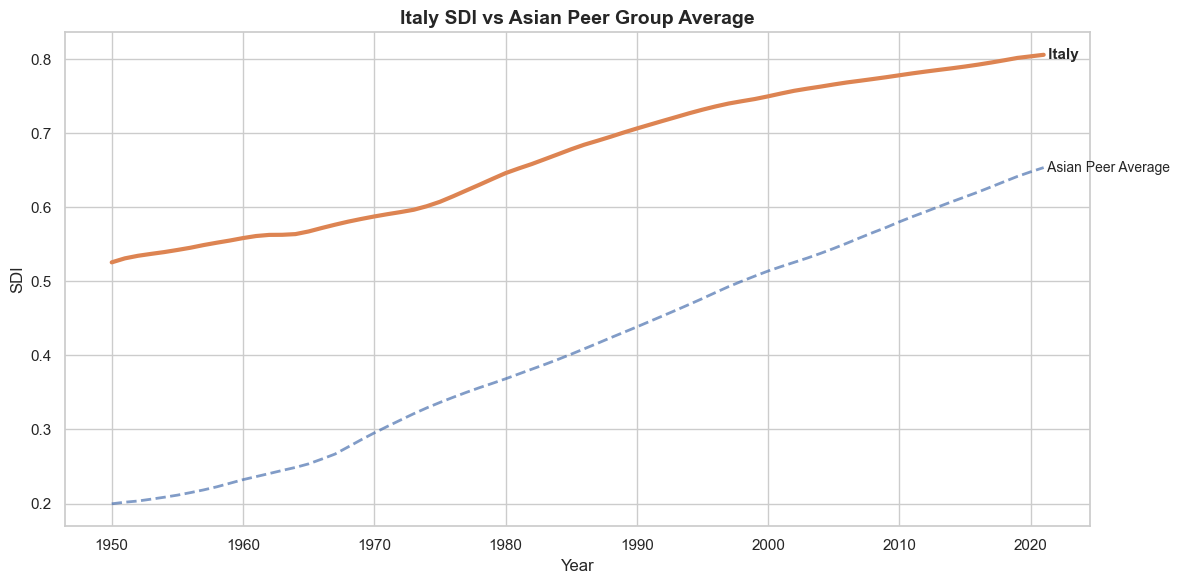

In [80]:
plt.figure(figsize=(12, 6))

# Peer group average
plt.plot(peer_avg['year'],peer_avg['sdi'],linestyle='--',linewidth=2,alpha=0.7)

# Italy
plt.plot(italy_temp['year'],italy_temp['sdi'],linewidth=3)

# Line labels (at the end) 
plt.text(italy_temp['year'].iloc[-1],italy_temp['sdi'].iloc[-1],' Italy',fontsize=11,fontweight='bold',va='center')
plt.text(peer_avg['year'].iloc[-1],peer_avg['sdi'].iloc[-1],' Asian Peer Average',fontsize=10,va='center')
plt.title('Italy SDI vs Asian Peer Group Average', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('SDI')

plt.tight_layout()
plt.show()
